In [1]:
# Import used libraries
import sys
import numpy as np
from scipy.stats import norm
from scipy.spatial.distance import pdist, squareform
import matplotlib
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
import loompy
import velocyto as vcy

from IPython.core.display import display, HTML
import logging
logging.basicConfig(stream=sys.stdout, format='%(asctime)s - %(levelname)s - %(message)s', level=logging.DEBUG)
display(HTML("<style>.container { width:90% !important; }</style>"))
# %matplotlib nbagg
%matplotlib inline

In [37]:
!mkdir data

In [39]:
from urllib.request import urlretrieve
urlretrieve("http://pklab.med.harvard.edu/velocyto/DentateGyrus/DentateGyrus.loom", "data/DentateGyrus.loom")

('data/DentateGyrus.loom', <http.client.HTTPMessage at 0x7ff714408898>)

# Load data

In [2]:
# Crate an analysis object
vlm = vcy.VelocytoLoom("data/DentateGyrus.loom")

In [3]:
# Read column attributes form the loom file and specify colors
vlm.ts = np.column_stack([vlm.ca["TSNE1"], vlm.ca["TSNE2"]])
colors_dict = {'RadialGlia': np.array([ 0.95,  0.6,  0.1]), 'RadialGlia2': np.array([ 0.85,  0.3,  0.1]), 'ImmAstro': np.array([ 0.8,  0.02,  0.1]),
              'GlialProg': np.array([ 0.81,  0.43,  0.72352941]), 'OPC': np.array([ 0.61,  0.13,  0.72352941]), 'nIPC': np.array([ 0.9,  0.8 ,  0.3]),
              'Nbl1': np.array([ 0.7,  0.82 ,  0.6]), 'Nbl2': np.array([ 0.448,  0.85490196,  0.95098039]),  'ImmGranule1': np.array([ 0.35,  0.4,  0.82]),
              'ImmGranule2': np.array([ 0.23,  0.3,  0.7]), 'Granule': np.array([ 0.05,  0.11,  0.51]), 'CA': np.array([ 0.2,  0.53,  0.71]),
               'CA1-Sub': np.array([ 0.1,  0.45,  0.3]), 'CA2-3-4': np.array([ 0.3,  0.35,  0.5])}
vlm.set_clusters(vlm.ca["ClusterName"], cluter_colors_dict=colors_dict)

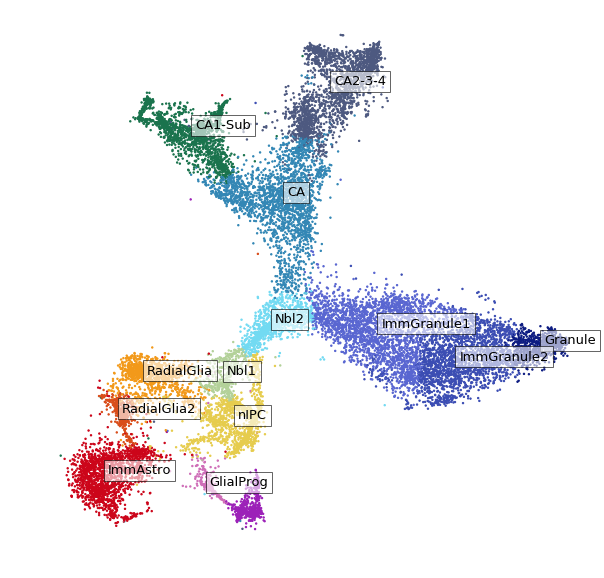

In [4]:
# Plot TSNE
plt.figure(figsize=(10,10))
vcy.scatter_viz(vlm.ts[:,0], vlm.ts[:,1], c=vlm.colorandum, s=2)
for i in range(max(vlm.ca["Clusters"])):
    ts_m = np.median(vlm.ts[vlm.ca["Clusters"] == i, :], 0)
    plt.text(ts_m[0], ts_m[1], str(vlm.cluster_labels[vlm.ca["Clusters"] == i][0]),
             fontsize=13, bbox={"facecolor":"w", "alpha":0.6})
plt.axis("off");

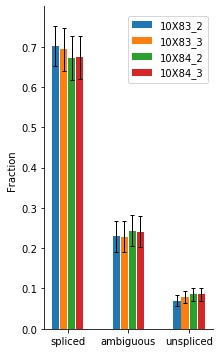

In [5]:
vlm.plot_fractions()

# Velocity Analysis

In [6]:
# This is called just to compute the initial cell size, normalized value will be recalculated
vlm.normalize("S", size=True,  log=False)
vlm.normalize("U", size=True,  log=False)

In [7]:
vlm.score_detection_levels(min_expr_counts=40, min_cells_express=30)
vlm.filter_genes(by_detection_levels=True)

2017-10-18 10:09:05,803 - DEBUG - Filtering by detection level


2017-10-18 10:09:09,029 - DEBUG - svr_gamma set to 0.01052262364082778
2017-10-18 10:09:13,880 - DEBUG - Filtering by cv vs mean


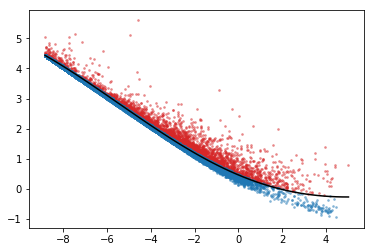

In [8]:
vlm.score_cv_vs_mean(3000, plot=True, max_expr_avg=35)
vlm.filter_genes(by_cv_vs_mean=True)

In [9]:
vlm.score_detection_levels(min_expr_counts=0, min_cells_express=0, min_expr_counts_U=25, min_cells_express_U=20)
vlm.score_cluster_expression(min_avg_U=0.01, min_avg_S=0.08)
vlm.filter_genes(by_detection_levels=True, by_cluster_expression=True)
vlm.normalize_by_total()
vlm.adjust_totS_totU(normalize_total=True)

2017-10-18 10:09:14,336 - INFO - Cluster: CA (2298 cells)
2017-10-18 10:09:14,436 - INFO - Cluster: CA1-Sub (1664 cells)
2017-10-18 10:09:14,506 - INFO - Cluster: CA2-3-4 (2129 cells)
2017-10-18 10:09:14,599 - INFO - Cluster: GlialProg (229 cells)
2017-10-18 10:09:14,611 - INFO - Cluster: Granule (863 cells)
2017-10-18 10:09:14,648 - INFO - Cluster: ImmAstro (1788 cells)
2017-10-18 10:09:14,724 - INFO - Cluster: ImmGranule1 (2460 cells)
2017-10-18 10:09:14,828 - INFO - Cluster: ImmGranule2 (2099 cells)
2017-10-18 10:09:14,918 - INFO - Cluster: Nbl1 (419 cells)
2017-10-18 10:09:14,939 - INFO - Cluster: Nbl2 (1003 cells)
2017-10-18 10:09:14,984 - INFO - Cluster: OPC (600 cells)
2017-10-18 10:09:15,010 - INFO - Cluster: RadialGlia (1043 cells)
2017-10-18 10:09:15,055 - INFO - Cluster: RadialGlia2 (388 cells)
2017-10-18 10:09:15,074 - INFO - Cluster: nIPC (1230 cells)
2017-10-18 10:09:15,128 - DEBUG - Filtering by cluster expression
2017-10-18 10:09:15,130 - DEBUG - Filtering by detection 

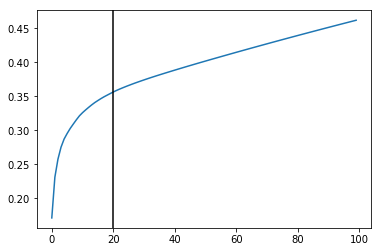

In [10]:
vlm.perform_PCA()
plt.plot(np.cumsum(vlm.pca.explained_variance_ratio_)[:100])
n_comps = np.where(np.diff(np.diff(np.cumsum(vlm.pca.explained_variance_ratio_))>0.002))[0][0]
plt.axvline(n_comps, c="k")

In [11]:
k = 500
vlm.knn_imputation(n_pca_dims=n_comps, k=k, balanced=True, b_sight=k*8, b_maxl=k*4, n_jobs=16)

2017-10-18 10:09:41,479 - DEBUG - First search the 4000 nearest neighbours for 18213
2017-10-18 10:09:56,207 - DEBUG - Using the initialization network to find a 500-NN graph with maximum connectivity of 2000
2017-10-18 10:09:56,857 - DEBUG - Returning sparse matrix


In [12]:
vlm.normalize_median()
vlm.fit_gammas(limit_gamma=True)

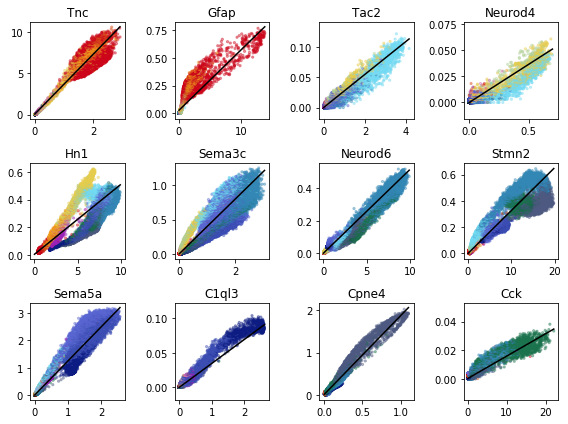

In [13]:
plt.figure(None, (8,6))
gs = plt.GridSpec(3,4)
for i, gn in enumerate(["Tnc", "Gfap", "Tac2","Neurod4", 'Hn1', "Sema3c", "Neurod6", "Stmn2", "Sema5a", "C1ql3", "Cpne4", "Cck"]):
    plt.subplot(gs[i])
    ix=np.where(vlm.ra["Gene"] == gn)[0][0]
    vcy.scatter_viz(vlm.Sx_sz[ix,:], vlm.Ux_sz[ix,:], c=vlm.colorandum, s=5, alpha=0.4)
    plt.title(gn)
    xnew = np.linspace(0,vlm.Sx[ix,:].max())
    plt.plot(xnew, vlm.gammas[ix] * xnew + vlm.q[ix], c="k")
plt.tight_layout()

In [14]:
vlm.predict_U()
vlm.calculate_velocity()
vlm.calculate_shift(assumption="constant_velocity")
vlm.extrapolate_cell_at_t(delta_t=1)

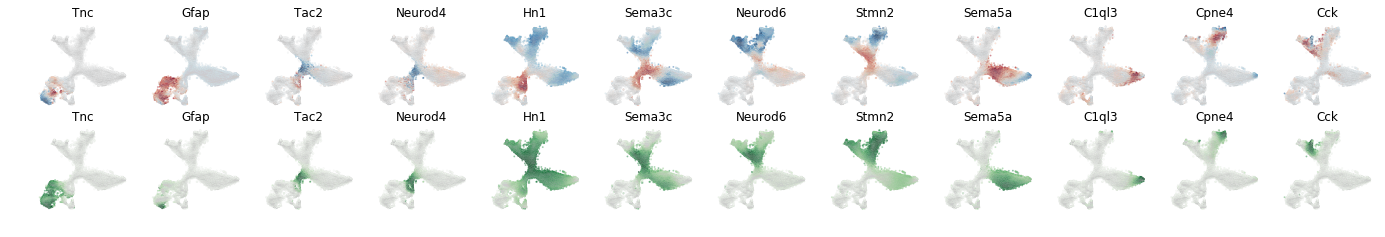

In [15]:
plt.figure(None, (24,3.5))
gs = plt.GridSpec(2,12)
for i, gn in enumerate(["Tnc", "Gfap", "Tac2","Neurod4", 'Hn1', "Sema3c", "Neurod6", "Stmn2", "Sema5a", "C1ql3", "Cpne4", "Cck"]):
    vlm.plot_velocity_as_color(gene_name=gn, gs=gs[0,i], s=3)
    vlm.plot_expression_as_color(gene_name=gn, gs=gs[1, i], s=3)

In [16]:
vlm.estimate_transition_prob(hidim="Sx_sz", embed="ts", transform="sqrt",
                             n_neighbors=4000, knn_random=True, sampled_fraction=1)

2017-10-18 10:11:47,321 - DEBUG - Calculate KNN in the embedding space
2017-10-18 10:12:29,413 - DEBUG - Correlation Calculation 'knn_random'
2017-10-18 10:18:51,289 - DEBUG - Done Correlation Calculation


In [17]:
vlm.calculate_embedding_shift(sigma_corr = 0.05)

2017-10-18 10:18:51,299 - DEBUG - Calculate transition probability


(-23.847362133670785,
 28.430140522493282,
 -22.531494023226706,
 26.7547472702608)

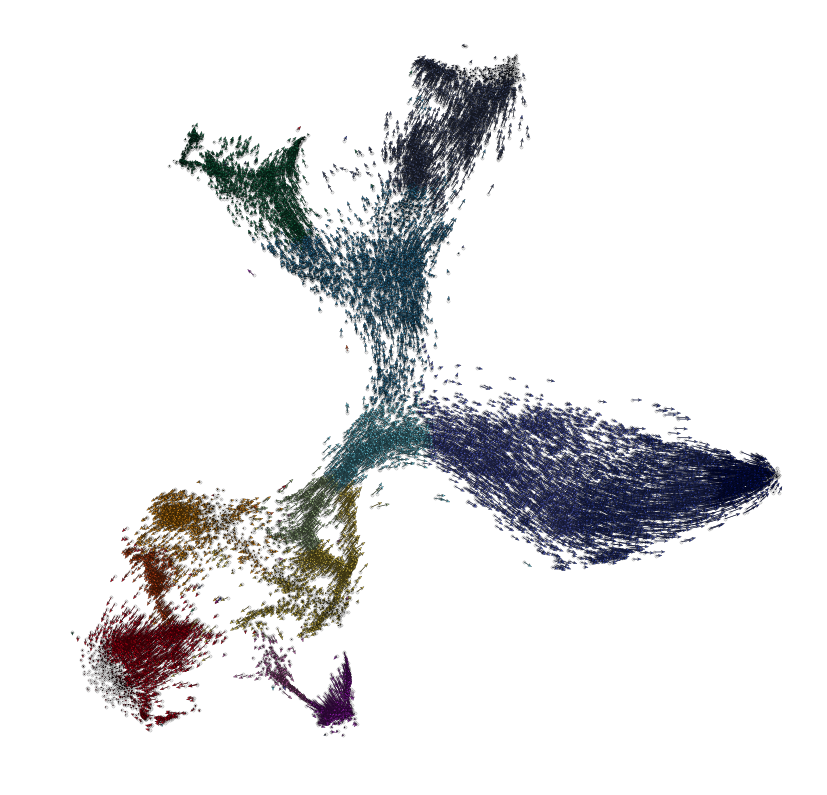

In [18]:
plt.figure(None,(14,14))
quiver_scale = 60

plt.scatter(vlm.embedding[:, 0], vlm.embedding[:, 1],
            c="0.8", alpha=0.2, s=10, edgecolor="")

ix_choice = np.random.choice(vlm.embedding.shape[0], size=int(vlm.embedding.shape[0]/1.), replace=False)
plt.scatter(vlm.embedding[ix_choice, 0], vlm.embedding[ix_choice, 1],
            c="0.8", alpha=0.4, s=10, edgecolor=(0,0,0,1), lw=0.3)

quiver_kwargs=dict(headaxislength=7, headlength=11, headwidth=8,linewidths=0.25, width=0.00045,edgecolors="k", color=vlm.colorandum[ix_choice], alpha=1)
plt.quiver(vlm.embedding[ix_choice, 0], vlm.embedding[ix_choice, 1],
           vlm.delta_embedding[ix_choice, 0], vlm.delta_embedding[ix_choice, 1],
           scale=quiver_scale, **quiver_kwargs)

plt.axis("off")

In [19]:
vlm.calculate_grid_arrows(smooth=0.8, steps=(40, 40), n_neighbors=300)

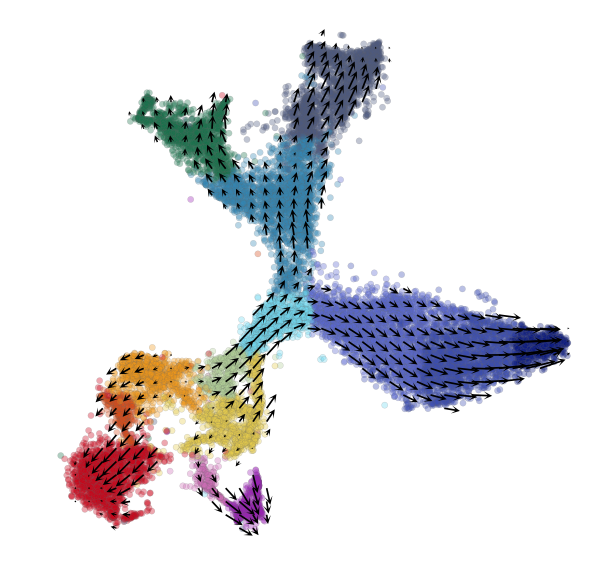

In [20]:
plt.figure(None,(10,10))
vlm.plot_grid_arrows(scatter_kwargs_dict={"alpha":0.35, "lw":0.35, "edgecolor":"0.4", "s":38, "rasterized":True}, min_mass=24, angles='xy', scale_units='xy',
                     headaxislength=2.75, headlength=5, headwidth=4.8, quiver_scale=0.47)

# Produce non default plots

In [21]:
def gaussian_kernel(X, mu = 0, sigma=1):
    return np.exp(-(X - mu)**2 / (2*sigma**2)) / np.sqrt(2*np.pi*sigma**2)

(-5.5, 7.5)

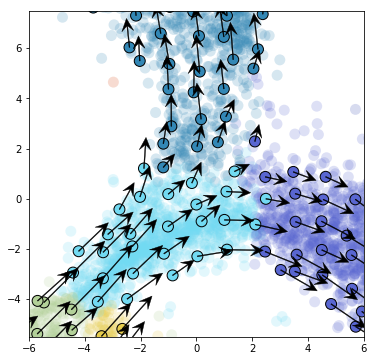

In [22]:
plt.figure(None,(6,6))

steps = 45, 45
grs = []
for dim_i in range(vlm.embedding.shape[1]):
    m, M = np.min(vlm.embedding[:, dim_i]), np.max(vlm.embedding[:, dim_i])
    m = m - 0.025 * np.abs(M - m)
    M = M + 0.025 * np.abs(M - m)
    gr = np.linspace(m, M, steps[dim_i])
    grs.append(gr)

meshes_tuple = np.meshgrid(*grs)
gridpoints_coordinates = np.vstack([i.flat for i in meshes_tuple]).T
gridpoints_coordinates = gridpoints_coordinates + norm.rvs(loc=0, scale=0.15, size=gridpoints_coordinates.shape)

nn = NearestNeighbors()
nn.fit(vlm.embedding)
dist, ixs = nn.kneighbors(gridpoints_coordinates, 20)
ix_choice = ixs[:,0].flat[:]
ix_choice = np.unique(ix_choice)

nn = NearestNeighbors()
nn.fit(vlm.embedding)
dist, ixs = nn.kneighbors(vlm.embedding[ix_choice], 20)
density_extimate = gaussian_kernel(dist, mu=0, sigma=0.5).sum(1)
bool_density = density_extimate > np.percentile(density_extimate, 25)
ix_choice = ix_choice[bool_density]

plt.scatter(vlm.embedding[:, 0], vlm.embedding[:, 1],
            c=vlm.colorandum, alpha=0.2, s=120, edgecolor="")
plt.scatter(vlm.embedding[ix_choice, 0], vlm.embedding[ix_choice, 1],
            c=vlm.colorandum[ix_choice], alpha=1, s=120, edgecolor="k")

quiver_kwargs=dict(scale=6.8, headaxislength=9, headlength=15, headwidth=14,linewidths=0.4, edgecolors="k", color="k", alpha=1)
plt.quiver(vlm.embedding[ix_choice, 0], vlm.embedding[ix_choice, 1],
           vlm.delta_embedding[ix_choice, 0], vlm.delta_embedding[ix_choice, 1],
           **quiver_kwargs)

plt.xlim(-6.,6) 
plt.ylim(-5.5,7.5)

(-20.5, -14)

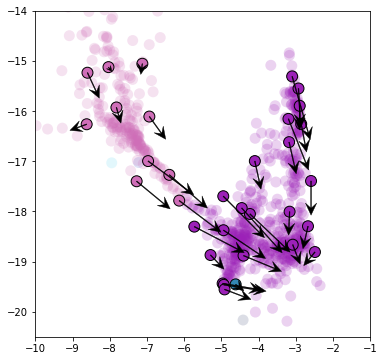

In [23]:
plt.figure(None,(6,6))

steps = 55, 55
grs = []
for dim_i in range(vlm.embedding.shape[1]):
    m, M = np.min(vlm.embedding[:, dim_i]), np.max(vlm.embedding[:, dim_i])
    m = m - 0.025 * np.abs(M - m)
    M = M + 0.025 * np.abs(M - m)
    gr = np.linspace(m, M, steps[dim_i])
    grs.append(gr)

meshes_tuple = np.meshgrid(*grs)
gridpoints_coordinates = np.vstack([i.flat for i in meshes_tuple]).T
gridpoints_coordinates = gridpoints_coordinates + norm.rvs(loc=0, scale=0.15, size=gridpoints_coordinates.shape)

from sklearn.neighbors import NearestNeighbors
nn = NearestNeighbors()
nn.fit(vlm.embedding)
dist, ixs = nn.kneighbors(gridpoints_coordinates, 20)
ix_choice = ixs[:,0].flat[:]
ix_choice = np.unique(ix_choice)

nn = NearestNeighbors()
nn.fit(vlm.embedding)
dist, ixs = nn.kneighbors(vlm.embedding[ix_choice], 20)
density_extimate = gaussian_kernel(dist, mu=0, sigma=0.5).sum(1)
bool_density = density_extimate > np.percentile(density_extimate, 30)
ix_choice = ix_choice[bool_density]

plt.scatter(vlm.embedding[:, 0], vlm.embedding[:, 1],
            c=vlm.colorandum, alpha=0.2, s=120, edgecolor="")

plt.scatter(vlm.embedding[ix_choice, 0], vlm.embedding[ix_choice, 1],
            c=vlm.colorandum[ix_choice], alpha=1, s=120, edgecolor="k")

quiver_kwargs=dict(scale=6.8, headaxislength=9, headlength=15, headwidth=14,linewidths=0.4, edgecolors="k", color="k", alpha=1)
#quiver_kwargs=dict(headaxislength=8, headlength=10, headwidth=1,linewidths=0.1, edgecolors="k", color=self.colorandum[ix_choice])


plt.quiver(vlm.embedding[ix_choice, 0], vlm.embedding[ix_choice, 1],
           vlm.delta_embedding[ix_choice, 0], vlm.delta_embedding[ix_choice, 1],
           **quiver_kwargs)

plt.xlim(-10,-1)
plt.ylim(-20.5,-14)

In [24]:
transition_probs = np.copy(vlm.transition_prob)

5.60602953649e-06
0.000624082225331
3.43581951606e-06
0.000611882708354


(-5.5, 7.5)

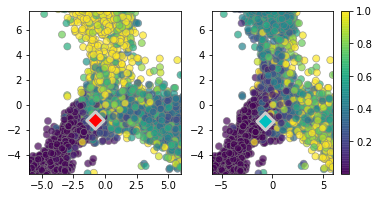

In [25]:
plt.figure(None,(6,3))
plt.subplot(121)
ix1 = 10997
ix = ix1
neigh_bool = (vlm.embedding_knn[ix,:].A[0] > 0)
colorandum = vlm.transition_prob[ix,:][neigh_bool]
print(np.percentile(colorandum, 10))
print(np.percentile(colorandum, 90))
colorandum -= 1e-6 
colorandum = colorandum / 6e-4
colorandum = np.clip(colorandum, 0, 1)
plt.scatter(vlm.embedding[neigh_bool,:][:, 0], vlm.embedding[neigh_bool,:][:, 1],
            c=plt.cm.viridis(colorandum), alpha=0.7, lw=0.7, s=50, edgecolor="0.5")
plt.scatter(vlm.embedding[ix, 0], vlm.embedding[ix, 1],
            c="r", alpha=1, s=150, lw=3, edgecolor="0.8", marker="D")
plt.xlim(-6.,6)
plt.ylim(-5.5,7.5)

plt.subplot(122)
ix2 = 10673
ix = ix2

neigh_bool = (vlm.embedding_knn[ix,:].A[0] > 0)
colorandum = vlm.transition_prob[ix,:][neigh_bool]
print(np.percentile(colorandum, 10))
print(np.percentile(colorandum, 90))
colorandum -= 1e-6
colorandum = colorandum / 6e-4
colorandum = np.clip(colorandum, 0, 1)
plt.scatter(vlm.embedding[neigh_bool,:][:, 0], vlm.embedding[neigh_bool,:][:, 1],
            c=colorandum,cmap=plt.cm.viridis, alpha=0.7, lw=0.7, s=50, edgecolor="0.5")
plt.colorbar()
plt.scatter(vlm.embedding[ix, 0], vlm.embedding[ix, 1],
            c="c", alpha=1, s=150, lw=3, edgecolor="0.8", marker="D")
plt.xlim(-6.,6)
plt.xlim(-6.,6)
plt.ylim(-5.5,7.5)

0.000119896295489
0.000397837669556
4.32690515329e-06
0.000726331862534


(-20.5, -14)

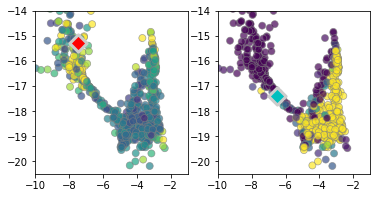

In [26]:
plt.figure(None,(6,3))
plt.subplot(121)
ix1 = 13549
ix = ix1
neigh_bool = (vlm.embedding_knn[ix,:].A[0] > 0)
colorandum = vlm.transition_prob[ix,:][neigh_bool]
print(np.percentile(colorandum, 10))
print(np.percentile(colorandum, 90))
colorandum -= 1e-5 
colorandum = colorandum / 4e-4
colorandum = np.clip(colorandum, 0, 1)
plt.scatter(vlm.embedding[neigh_bool,:][:, 0], vlm.embedding[neigh_bool,:][:, 1],
            c=plt.cm.viridis(colorandum), alpha=0.7, lw=0.7, s=50, edgecolor="0.5")
plt.scatter(vlm.embedding[ix, 0], vlm.embedding[ix, 1],
            c="r", alpha=1, s=150, lw=3, edgecolor="0.8", marker="D")
plt.xlim(-10,-1)
plt.ylim(-20.5,-14)

plt.subplot(122)
ix2 = 13669
ix = ix2

neigh_bool = (vlm.embedding_knn[ix,:].A[0] > 0)
colorandum = vlm.transition_prob[ix,:][neigh_bool]
print(np.percentile(colorandum, 10))
print(np.percentile(colorandum, 90))
colorandum -= 1e-5
colorandum = colorandum / 4e-4
colorandum = np.clip(colorandum, 0, 1)
plt.scatter(vlm.embedding[neigh_bool,:][:, 0], vlm.embedding[neigh_bool,:][:, 1],
            c=colorandum,cmap=plt.cm.viridis, alpha=0.7, lw=0.7, s=50, edgecolor="0.5")
#plt.colorbar()
plt.scatter(vlm.embedding[ix, 0], vlm.embedding[ix, 1],
            c="c", alpha=1, s=150, lw=3, edgecolor="0.8", marker="D")
plt.xlim(-10,-1)
plt.ylim(-20.5,-14)

## Markov chain

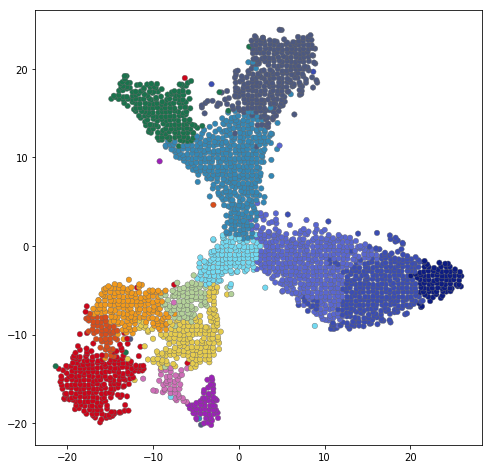

In [27]:
# Sample uniformly the points to avoid density driven effects - Should reimplement as a method
steps = 100, 100
grs = []
for dim_i in range(vlm.embedding.shape[1]):
    m, M = np.min(vlm.embedding[:, dim_i]), np.max(vlm.embedding[:, dim_i])
    m = m - 0.025 * np.abs(M - m)
    M = M + 0.025 * np.abs(M - m)
    gr = np.linspace(m, M, steps[dim_i])
    grs.append(gr)

meshes_tuple = np.meshgrid(*grs)
gridpoints_coordinates = np.vstack([i.flat for i in meshes_tuple]).T

from sklearn.neighbors import NearestNeighbors
nn = NearestNeighbors()
nn.fit(vlm.embedding)
dist, ixs = nn.kneighbors(gridpoints_coordinates, 1)

diag_step_dist = np.sqrt((meshes_tuple[0][0,0] - meshes_tuple[0][0,1])**2 + (meshes_tuple[1][0,0] - meshes_tuple[1][1,0])**2)
min_dist = diag_step_dist / 2
ixs = ixs[dist < min_dist]
gridpoints_coordinates = gridpoints_coordinates[dist.flat[:]<min_dist,:]
dist = dist[dist < min_dist]

ixs = np.unique(ixs)

plt.figure(None,(8,8))
vcy.scatter_viz(vlm.embedding[ixs, 0], vlm.embedding[ixs, 1],
                c=vlm.colorandum[ixs], alpha=1, s=30, lw=0.4,
                edgecolor="0.4")

In [28]:
vlm.prepare_markov(sigma_D=diag_step_dist, sigma_W=diag_step_dist/2., direction='forward', cells_ixs=ixs)

In [29]:
vlm.run_markov(starting_p=np.ones(len(ixs)), n_steps=2500)

(-23.741435026940046,
 28.32421341576255,
 -22.429579613721042,
 26.652832860755147)

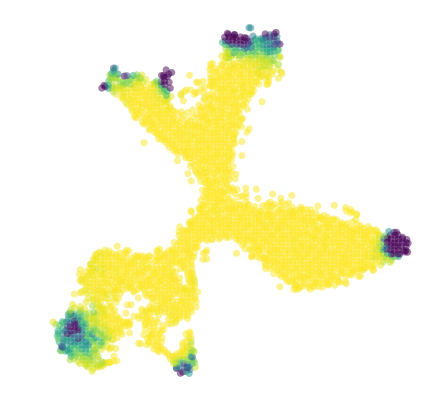

In [34]:
diffused_n = vlm.diffused - np.percentile(vlm.diffused, 3)
diffused_n /= np.percentile(diffused_n, 97)
diffused_n = np.clip(diffused_n, 0, 1)

plt.figure(None,(7,7))
vcy.scatter_viz(vlm.embedding[ixs, 0], vlm.embedding[ixs, 1],
                c=diffused_n, alpha=0.5, s=50, lw=0.,
                edgecolor="", cmap="viridis_r")
plt.axis("off")
#plt.savefig("/data/proj/velocity/endpoint_distr.pdf")

In [35]:
vlm.prepare_markov(sigma_D=diag_step_dist, sigma_W=diag_step_dist/2., direction='backwards', cells_ixs=ixs)
vlm.run_markov(starting_p=np.ones(len(ixs)), n_steps=2500)

(-23.741435026940046,
 28.32421341576255,
 -22.429579613721042,
 26.652832860755147)

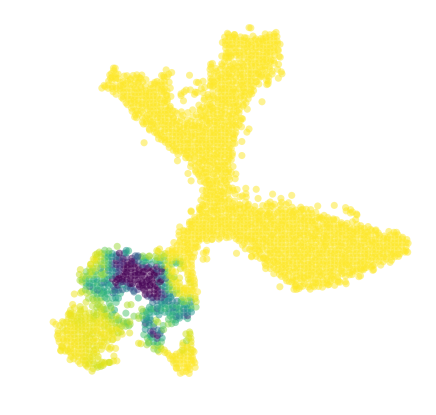

In [36]:
diffused_n = vlm.diffused - np.percentile(vlm.diffused, 3)
diffused_n /= np.percentile(diffused_n, 97)
diffused_n = np.clip(diffused_n, 0, 1)

plt.figure(None,(7,7))
vcy.scatter_viz(vlm.embedding[ixs, 0], vlm.embedding[ixs, 1],
                c=diffused_n, alpha=0.5, s=50, lw=0.,
                edgecolor="", cmap="viridis_r")
plt.axis("off")